In [15]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = "cuda"
epochs = 300
batch_size = 128

In [17]:
LOAD_CHECKPOINT = False
CHECKPOINT_NAME = "sig2-SimCLR.pt"

DATASET = "sig2"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 1
elif DATASET == "sig2":
    TARGET_CLASS = 2
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [18]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
elif DATASET == "sig2":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=2)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [19]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [20]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [21]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [22]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [23]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

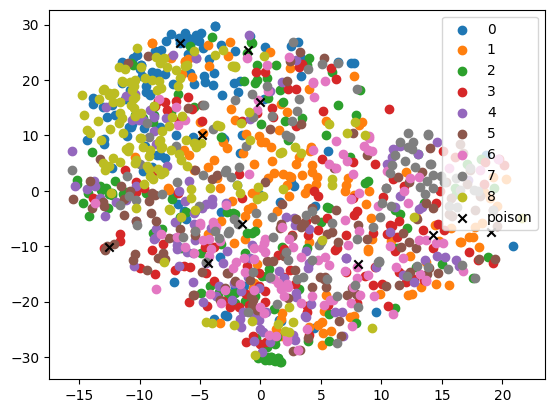

In [24]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [25]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [26]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [27]:
start_epoch = 0

load_checkpoint = False

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [0/300]	
	Step [0/391]	 Loss: 5.1064
	Step [50/391]	 Loss: 4.4394
	Step [100/391]	 Loss: 4.15071
	Step [150/391]	 Loss: 3.96433
	Step [200/391]	 Loss: 3.93686
	Step [250/391]	 Loss: 3.83788
	Step [300/391]	 Loss: 3.81713
	Step [350/391]	 Loss: 3.7921

	Training Loss: 4.049730556395352
	Time Taken: 3.6463043729464215 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR-0.pt


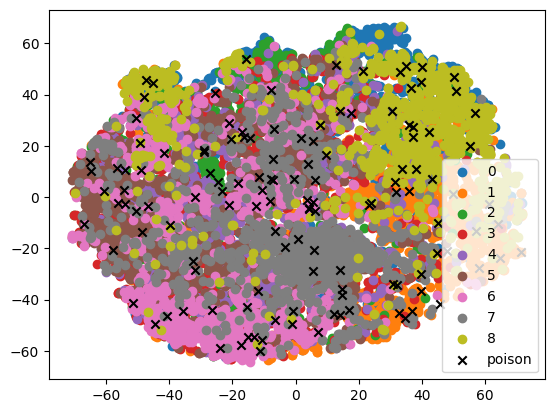

Epoch [1/300]	
	Step [0/391]	 Loss: 3.74988
	Step [50/391]	 Loss: 3.77682
	Step [100/391]	 Loss: 3.77868
	Step [150/391]	 Loss: 3.77024
	Step [200/391]	 Loss: 3.79379
	Step [250/391]	 Loss: 3.75621
	Step [300/391]	 Loss: 3.74384
	Step [350/391]	 Loss: 3.74433

	Training Loss: 3.7691196840437478
	Time Taken: 3.609333312511444 minutes
Epoch [2/300]	
	Step [0/391]	 Loss: 3.76442
	Step [50/391]	 Loss: 3.76478
	Step [100/391]	 Loss: 3.74107
	Step [150/391]	 Loss: 3.74311
	Step [200/391]	 Loss: 3.73591
	Step [250/391]	 Loss: 3.75252
	Step [300/391]	 Loss: 3.73937
	Step [350/391]	 Loss: 3.75952

	Training Loss: 3.7489485100407123
	Time Taken: 3.6014333248138426 minutes
Epoch [3/300]	
	Step [0/391]	 Loss: 3.75032
	Step [50/391]	 Loss: 3.74034
	Step [100/391]	 Loss: 3.74698
	Step [150/391]	 Loss: 3.72887
	Step [200/391]	 Loss: 3.73841
	Step [250/391]	 Loss: 3.72319
	Step [300/391]	 Loss: 3.72501
	Step [350/391]	 Loss: 3.71297

	Training Loss: 3.7326247356736753
	Time Taken: 3.5976505875587463 m

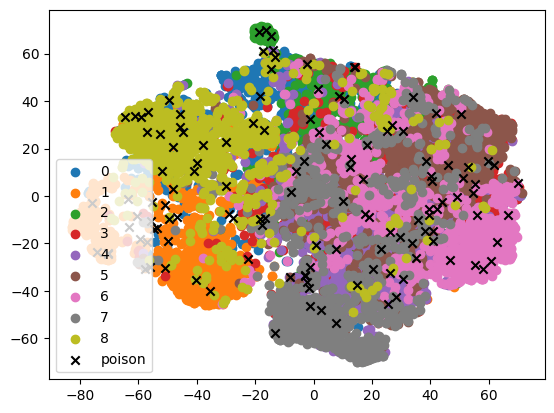

Epoch [11/300]	
	Step [0/391]	 Loss: 3.66498
	Step [50/391]	 Loss: 3.67097
	Step [100/391]	 Loss: 3.67255
	Step [150/391]	 Loss: 3.66939
	Step [200/391]	 Loss: 3.66548
	Step [250/391]	 Loss: 3.65826
	Step [300/391]	 Loss: 3.6619
	Step [350/391]	 Loss: 3.67268

	Training Loss: 3.6662027134614834
	Time Taken: 3.5976333340009052 minutes
Epoch [12/300]	
	Step [0/391]	 Loss: 3.67397
	Step [50/391]	 Loss: 3.65874
	Step [100/391]	 Loss: 3.66388
	Step [150/391]	 Loss: 3.67292
	Step [200/391]	 Loss: 3.64775
	Step [250/391]	 Loss: 3.6595
	Step [300/391]	 Loss: 3.66969
	Step [350/391]	 Loss: 3.65295

	Training Loss: 3.6607287491069123
	Time Taken: 3.6007833162943523 minutes
Epoch [13/300]	
	Step [0/391]	 Loss: 3.66615
	Step [50/391]	 Loss: 3.6652
	Step [100/391]	 Loss: 3.66047
	Step [150/391]	 Loss: 3.66279
	Step [200/391]	 Loss: 3.66555
	Step [250/391]	 Loss: 3.66702
	Step [300/391]	 Loss: 3.6512
	Step [350/391]	 Loss: 3.65863

	Training Loss: 3.6576437553786256
	Time Taken: 3.597450009981791 mi

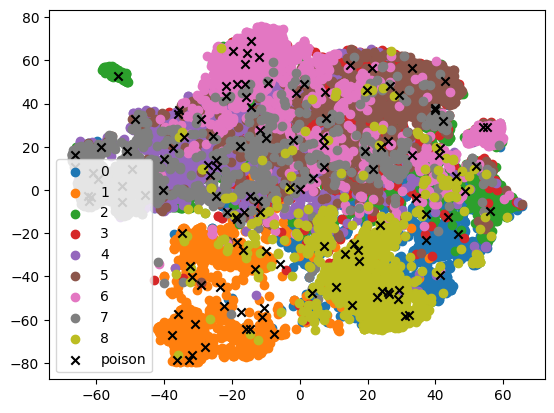

Epoch [21/300]	
	Step [0/391]	 Loss: 3.63647
	Step [50/391]	 Loss: 3.63887
	Step [100/391]	 Loss: 3.64737
	Step [150/391]	 Loss: 3.64155
	Step [200/391]	 Loss: 3.65443
	Step [250/391]	 Loss: 3.64151
	Step [300/391]	 Loss: 3.6378
	Step [350/391]	 Loss: 3.62846

	Training Loss: 3.641331663521964
	Time Taken: 3.6047167857487996 minutes
Epoch [22/300]	
	Step [0/391]	 Loss: 3.64365
	Step [50/391]	 Loss: 3.64621
	Step [100/391]	 Loss: 3.63485
	Step [150/391]	 Loss: 3.63599
	Step [200/391]	 Loss: 3.63808
	Step [250/391]	 Loss: 3.65583
	Step [300/391]	 Loss: 3.63886
	Step [350/391]	 Loss: 3.64024

	Training Loss: 3.640140909673003
	Time Taken: 3.60003483692805 minutes
Epoch [23/300]	
	Step [0/391]	 Loss: 3.63985
	Step [50/391]	 Loss: 3.64275
	Step [100/391]	 Loss: 3.64356
	Step [150/391]	 Loss: 3.64973
	Step [200/391]	 Loss: 3.6481
	Step [250/391]	 Loss: 3.64242
	Step [300/391]	 Loss: 3.63395
	Step [350/391]	 Loss: 3.64544

	Training Loss: 3.638725867356791
	Time Taken: 3.600100032488505 minut

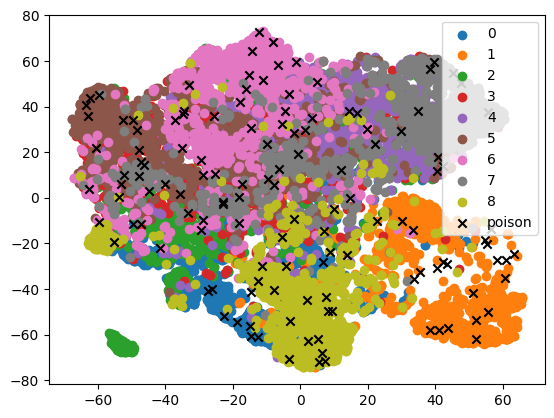

Epoch [31/300]	
	Step [0/391]	 Loss: 3.63004
	Step [50/391]	 Loss: 3.63485
	Step [100/391]	 Loss: 3.63435
	Step [150/391]	 Loss: 3.64094
	Step [200/391]	 Loss: 3.63433
	Step [250/391]	 Loss: 3.62283
	Step [300/391]	 Loss: 3.63208
	Step [350/391]	 Loss: 3.62728

	Training Loss: 3.6302994974433918
	Time Taken: 3.601799515883128 minutes
Epoch [32/300]	
	Step [0/391]	 Loss: 3.64466
	Step [50/391]	 Loss: 3.62554
	Step [100/391]	 Loss: 3.62677
	Step [150/391]	 Loss: 3.6333
	Step [200/391]	 Loss: 3.63322
	Step [250/391]	 Loss: 3.62616
	Step [300/391]	 Loss: 3.62808
	Step [350/391]	 Loss: 3.62952

	Training Loss: 3.6294669769609067
	Time Taken: 3.5912999828656513 minutes
Epoch [33/300]	
	Step [0/391]	 Loss: 3.632
	Step [50/391]	 Loss: 3.62349
	Step [100/391]	 Loss: 3.63302
	Step [150/391]	 Loss: 3.62956
	Step [200/391]	 Loss: 3.63018
	Step [250/391]	 Loss: 3.64609
	Step [300/391]	 Loss: 3.63498
	Step [350/391]	 Loss: 3.62979

	Training Loss: 3.6287591274437085
	Time Taken: 3.6033666650454204 m

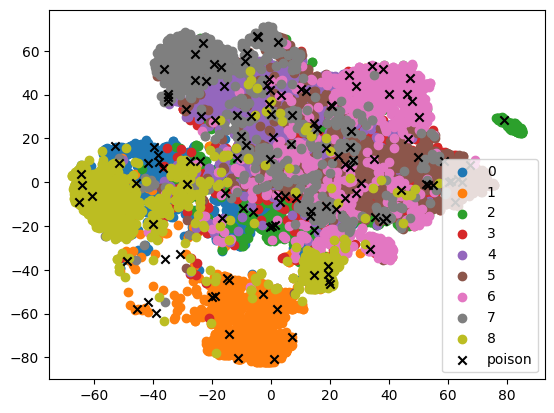

Epoch [41/300]	
	Step [0/391]	 Loss: 3.62251
	Step [50/391]	 Loss: 3.62941
	Step [100/391]	 Loss: 3.62958
	Step [150/391]	 Loss: 3.62307
	Step [200/391]	 Loss: 3.63273
	Step [250/391]	 Loss: 3.62976
	Step [300/391]	 Loss: 3.62406
	Step [350/391]	 Loss: 3.62203

	Training Loss: 3.623585359519705
	Time Taken: 3.600366147359212 minutes
Epoch [42/300]	
	Step [0/391]	 Loss: 3.62115
	Step [50/391]	 Loss: 3.61872
	Step [100/391]	 Loss: 3.62759
	Step [150/391]	 Loss: 3.61715
	Step [200/391]	 Loss: 3.62331
	Step [250/391]	 Loss: 3.62674
	Step [300/391]	 Loss: 3.62757
	Step [350/391]	 Loss: 3.62001

	Training Loss: 3.623024644754122
	Time Taken: 3.6020166794459025 minutes
Epoch [43/300]	
	Step [0/391]	 Loss: 3.61251
	Step [50/391]	 Loss: 3.62081
	Step [100/391]	 Loss: 3.62664
	Step [150/391]	 Loss: 3.61912
	Step [200/391]	 Loss: 3.62442
	Step [250/391]	 Loss: 3.62858
	Step [300/391]	 Loss: 3.62465
	Step [350/391]	 Loss: 3.62493

	Training Loss: 3.6221838753546596
	Time Taken: 3.5950166543324786 

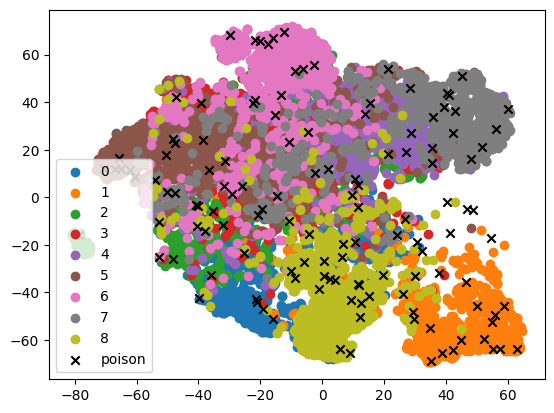

Epoch [51/300]	
	Step [0/391]	 Loss: 3.61947
	Step [50/391]	 Loss: 3.63172
	Step [100/391]	 Loss: 3.61883
	Step [150/391]	 Loss: 3.62889
	Step [200/391]	 Loss: 3.61431
	Step [250/391]	 Loss: 3.61383
	Step [300/391]	 Loss: 3.61478
	Step [350/391]	 Loss: 3.62594

	Training Loss: 3.618510835920758
	Time Taken: 3.5998499910036723 minutes
Epoch [52/300]	
	Step [0/391]	 Loss: 3.61255
	Step [50/391]	 Loss: 3.61757
	Step [100/391]	 Loss: 3.6319
	Step [150/391]	 Loss: 3.62104
	Step [200/391]	 Loss: 3.61743
	Step [250/391]	 Loss: 3.62522
	Step [300/391]	 Loss: 3.61888
	Step [350/391]	 Loss: 3.62304

	Training Loss: 3.6185140109732936
	Time Taken: 3.6014166553815206 minutes
Epoch [53/300]	
	Step [0/391]	 Loss: 3.62098
	Step [50/391]	 Loss: 3.61741
	Step [100/391]	 Loss: 3.62203
	Step [150/391]	 Loss: 3.61692
	Step [200/391]	 Loss: 3.6128
	Step [250/391]	 Loss: 3.62199
	Step [300/391]	 Loss: 3.62436
	Step [350/391]	 Loss: 3.62929

	Training Loss: 3.6175720331918857
	Time Taken: 3.590133329232534 m

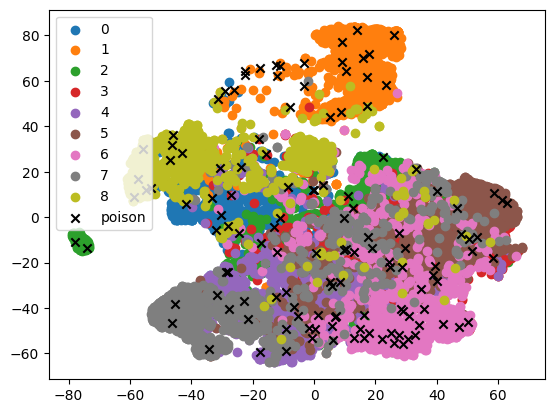

Epoch [61/300]	
	Step [0/391]	 Loss: 3.61086
	Step [50/391]	 Loss: 3.62571
	Step [100/391]	 Loss: 3.61669
	Step [150/391]	 Loss: 3.61056
	Step [200/391]	 Loss: 3.61738
	Step [250/391]	 Loss: 3.61197
	Step [300/391]	 Loss: 3.61855
	Step [350/391]	 Loss: 3.61906

	Training Loss: 3.6145998553546796
	Time Taken: 3.5993305404980975 minutes
Epoch [62/300]	
	Step [0/391]	 Loss: 3.61109
	Step [50/391]	 Loss: 3.61343
	Step [100/391]	 Loss: 3.61196
	Step [150/391]	 Loss: 3.61915
	Step [200/391]	 Loss: 3.6131
	Step [250/391]	 Loss: 3.61291
	Step [300/391]	 Loss: 3.61379
	Step [350/391]	 Loss: 3.61445

	Training Loss: 3.6143109133786253
	Time Taken: 3.5953690965970355 minutes
Epoch [63/300]	
	Step [0/391]	 Loss: 3.61582
	Step [50/391]	 Loss: 3.61123
	Step [100/391]	 Loss: 3.61087
	Step [150/391]	 Loss: 3.6095
	Step [200/391]	 Loss: 3.61498
	Step [250/391]	 Loss: 3.61103
	Step [300/391]	 Loss: 3.61729
	Step [350/391]	 Loss: 3.61871

	Training Loss: 3.613989331838115
	Time Taken: 3.601251947879791 m

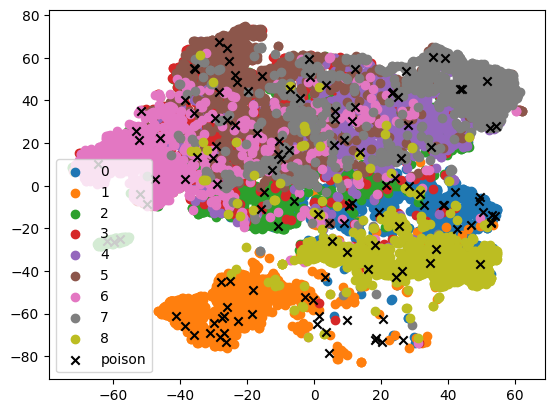

Epoch [71/300]	
	Step [0/391]	 Loss: 3.61192
	Step [50/391]	 Loss: 3.61255
	Step [100/391]	 Loss: 3.61468
	Step [150/391]	 Loss: 3.60916
	Step [200/391]	 Loss: 3.614
	Step [250/391]	 Loss: 3.61525
	Step [300/391]	 Loss: 3.61234
	Step [350/391]	 Loss: 3.61072

	Training Loss: 3.611633447734901
	Time Taken: 3.6039380351702373 minutes
Epoch [72/300]	
	Step [0/391]	 Loss: 3.60848
	Step [50/391]	 Loss: 3.61649
	Step [100/391]	 Loss: 3.61233
	Step [150/391]	 Loss: 3.62058
	Step [200/391]	 Loss: 3.6132
	Step [250/391]	 Loss: 3.61428
	Step [300/391]	 Loss: 3.61987
	Step [350/391]	 Loss: 3.61309

	Training Loss: 3.611329190871295
	Time Taken: 3.5984976569811504 minutes
Epoch [73/300]	
	Step [0/391]	 Loss: 3.61896
	Step [50/391]	 Loss: 3.60828
	Step [100/391]	 Loss: 3.61334
	Step [150/391]	 Loss: 3.61161
	Step [200/391]	 Loss: 3.61561
	Step [250/391]	 Loss: 3.61414
	Step [300/391]	 Loss: 3.61106
	Step [350/391]	 Loss: 3.61677

	Training Loss: 3.611322339538418
	Time Taken: 3.598472062746684 minu

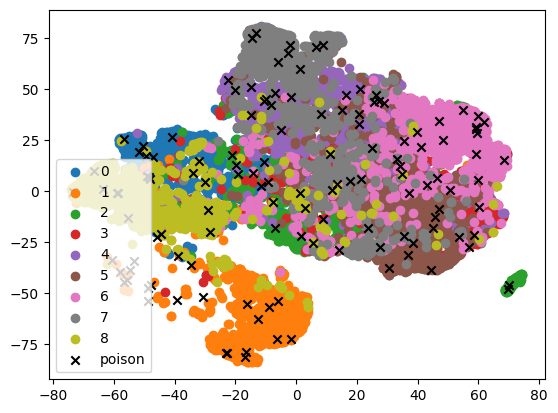

Epoch [81/300]	
	Step [0/391]	 Loss: 3.62072
	Step [50/391]	 Loss: 3.61978
	Step [100/391]	 Loss: 3.61009
	Step [150/391]	 Loss: 3.61342
	Step [200/391]	 Loss: 3.60715
	Step [250/391]	 Loss: 3.60756
	Step [300/391]	 Loss: 3.60633
	Step [350/391]	 Loss: 3.60751

	Training Loss: 3.609116360964373
	Time Taken: 3.602433677514394 minutes
Epoch [82/300]	
	Step [0/391]	 Loss: 3.61049
	Step [50/391]	 Loss: 3.60694
	Step [100/391]	 Loss: 3.60299
	Step [150/391]	 Loss: 3.61927
	Step [200/391]	 Loss: 3.61458
	Step [250/391]	 Loss: 3.61738
	Step [300/391]	 Loss: 3.60748
	Step [350/391]	 Loss: 3.60675

	Training Loss: 3.6089428830939485
	Time Taken: 3.596484347184499 minutes
Epoch [83/300]	
	Step [0/391]	 Loss: 3.61611
	Step [50/391]	 Loss: 3.60524
	Step [100/391]	 Loss: 3.60276
	Step [150/391]	 Loss: 3.61042
	Step [200/391]	 Loss: 3.60442
	Step [250/391]	 Loss: 3.61316
	Step [300/391]	 Loss: 3.61366
	Step [350/391]	 Loss: 3.60865

	Training Loss: 3.6086102940542313
	Time Taken: 3.5954843203226727 

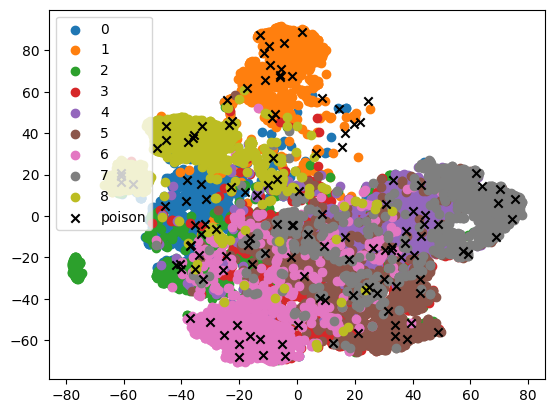

Epoch [91/300]	
	Step [0/391]	 Loss: 3.60798
	Step [50/391]	 Loss: 3.61236
	Step [100/391]	 Loss: 3.6094
	Step [150/391]	 Loss: 3.60333
	Step [200/391]	 Loss: 3.6013
	Step [250/391]	 Loss: 3.60688
	Step [300/391]	 Loss: 3.60923
	Step [350/391]	 Loss: 3.6079

	Training Loss: 3.6067248445642575
	Time Taken: 3.604907830556234 minutes
Epoch [92/300]	
	Step [0/391]	 Loss: 3.61249
	Step [50/391]	 Loss: 3.61174
	Step [100/391]	 Loss: 3.62334
	Step [150/391]	 Loss: 3.61394
	Step [200/391]	 Loss: 3.60803
	Step [250/391]	 Loss: 3.60082
	Step [300/391]	 Loss: 3.60776
	Step [350/391]	 Loss: 3.61112

	Training Loss: 3.606340064417066
	Time Taken: 3.5984251459439593 minutes
Epoch [93/300]	
	Step [0/391]	 Loss: 3.61039
	Step [50/391]	 Loss: 3.60782
	Step [100/391]	 Loss: 3.60151
	Step [150/391]	 Loss: 3.60498
	Step [200/391]	 Loss: 3.60543
	Step [250/391]	 Loss: 3.60759
	Step [300/391]	 Loss: 3.60654
	Step [350/391]	 Loss: 3.61195

	Training Loss: 3.6063690411160363
	Time Taken: 3.6003745595614114 mi

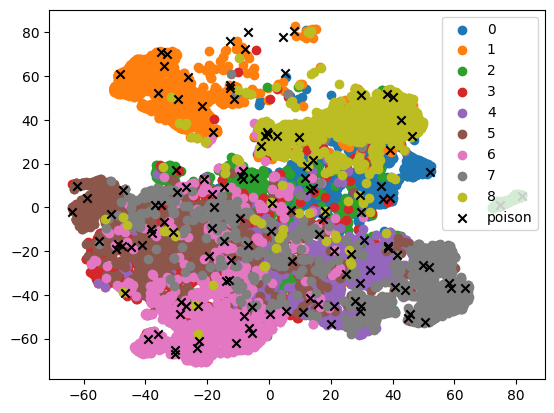

Epoch [101/300]	
	Step [0/391]	 Loss: 3.60889
	Step [50/391]	 Loss: 3.60469
	Step [100/391]	 Loss: 3.59948
	Step [150/391]	 Loss: 3.60972
	Step [200/391]	 Loss: 3.61097
	Step [250/391]	 Loss: 3.60133
	Step [300/391]	 Loss: 3.60255
	Step [350/391]	 Loss: 3.61394

	Training Loss: 3.6046183481240823
	Time Taken: 3.6070778608322143 minutes
Epoch [102/300]	
	Step [0/391]	 Loss: 3.60486
	Step [50/391]	 Loss: 3.60466
	Step [100/391]	 Loss: 3.61507
	Step [150/391]	 Loss: 3.60357
	Step [200/391]	 Loss: 3.6065
	Step [250/391]	 Loss: 3.60575
	Step [300/391]	 Loss: 3.61303
	Step [350/391]	 Loss: 3.60349

	Training Loss: 3.604348398535453
	Time Taken: 3.60216170946757 minutes
Epoch [103/300]	
	Step [0/391]	 Loss: 3.60937
	Step [50/391]	 Loss: 3.60791
	Step [100/391]	 Loss: 3.6145
	Step [150/391]	 Loss: 3.60107
	Step [200/391]	 Loss: 3.6026
	Step [250/391]	 Loss: 3.60611
	Step [300/391]	 Loss: 3.60815
	Step [350/391]	 Loss: 3.60634

	Training Loss: 3.6047070191034574
	Time Taken: 3.601432168483734 m

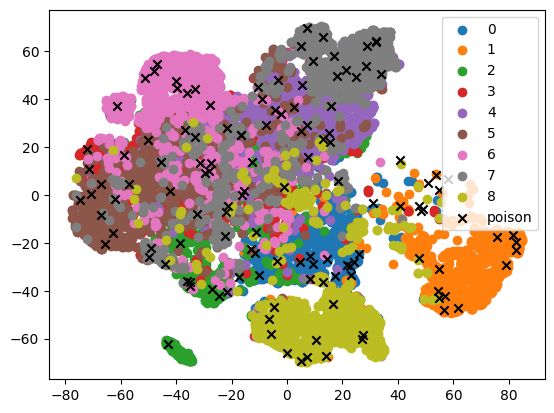

Epoch [111/300]	
	Step [0/391]	 Loss: 3.60535
	Step [50/391]	 Loss: 3.59884
	Step [100/391]	 Loss: 3.60098
	Step [150/391]	 Loss: 3.59913
	Step [200/391]	 Loss: 3.60448
	Step [250/391]	 Loss: 3.59651
	Step [300/391]	 Loss: 3.60718
	Step [350/391]	 Loss: 3.61042

	Training Loss: 3.6026670804718877
	Time Taken: 3.6008054773012796 minutes
Epoch [112/300]	
	Step [0/391]	 Loss: 3.60759
	Step [50/391]	 Loss: 3.60096
	Step [100/391]	 Loss: 3.60329
	Step [150/391]	 Loss: 3.60772
	Step [200/391]	 Loss: 3.60157
	Step [250/391]	 Loss: 3.60473
	Step [300/391]	 Loss: 3.60244
	Step [350/391]	 Loss: 3.6033

	Training Loss: 3.602711813529129
	Time Taken: 3.6036900440851847 minutes
Epoch [113/300]	
	Step [0/391]	 Loss: 3.60776
	Step [50/391]	 Loss: 3.61773
	Step [100/391]	 Loss: 3.60405
	Step [150/391]	 Loss: 3.60864
	Step [200/391]	 Loss: 3.60077
	Step [250/391]	 Loss: 3.61008
	Step [300/391]	 Loss: 3.60118
	Step [350/391]	 Loss: 3.60493

	Training Loss: 3.6027300918803498
	Time Taken: 3.6006254553794

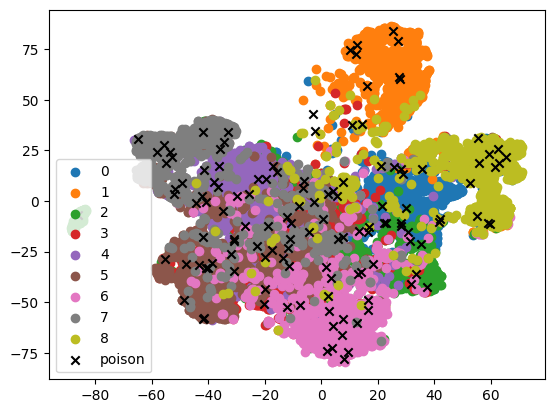

Epoch [121/300]	
	Step [0/391]	 Loss: 3.60005
	Step [50/391]	 Loss: 3.59841
	Step [100/391]	 Loss: 3.60014
	Step [150/391]	 Loss: 3.60112
	Step [200/391]	 Loss: 3.5999
	Step [250/391]	 Loss: 3.60392
	Step [300/391]	 Loss: 3.59913
	Step [350/391]	 Loss: 3.59703

	Training Loss: 3.600892309642509
	Time Taken: 3.6053773005803427 minutes
Epoch [122/300]	
	Step [0/391]	 Loss: 3.60101
	Step [50/391]	 Loss: 3.60177
	Step [100/391]	 Loss: 3.59994
	Step [150/391]	 Loss: 3.60303
	Step [200/391]	 Loss: 3.59408
	Step [250/391]	 Loss: 3.60508
	Step [300/391]	 Loss: 3.60322
	Step [350/391]	 Loss: 3.59968

	Training Loss: 3.6010968453438994
	Time Taken: 3.597612738609314 minutes
Epoch [123/300]	
	Step [0/391]	 Loss: 3.60074
	Step [50/391]	 Loss: 3.60039
	Step [100/391]	 Loss: 3.60464
	Step [150/391]	 Loss: 3.59637
	Step [200/391]	 Loss: 3.59631
	Step [250/391]	 Loss: 3.60437
	Step [300/391]	 Loss: 3.59966
	Step [350/391]	 Loss: 3.60165

	Training Loss: 3.600799844697918
	Time Taken: 3.603579366207122

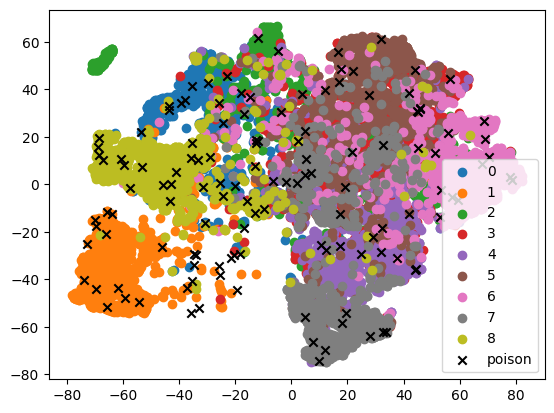

Epoch [131/300]	
	Step [0/391]	 Loss: 3.59721
	Step [50/391]	 Loss: 3.59936
	Step [100/391]	 Loss: 3.60153
	Step [150/391]	 Loss: 3.6064
	Step [200/391]	 Loss: 3.60123
	Step [250/391]	 Loss: 3.59518
	Step [300/391]	 Loss: 3.59876
	Step [350/391]	 Loss: 3.60021

	Training Loss: 3.599755645712928
	Time Taken: 3.605447793006897 minutes
Epoch [132/300]	
	Step [0/391]	 Loss: 3.59821
	Step [50/391]	 Loss: 3.60369
	Step [100/391]	 Loss: 3.59955
	Step [150/391]	 Loss: 3.59783
	Step [200/391]	 Loss: 3.59811
	Step [250/391]	 Loss: 3.59823
	Step [300/391]	 Loss: 3.59927
	Step [350/391]	 Loss: 3.60227

	Training Loss: 3.599510164821849
	Time Taken: 3.5998644471168517 minutes
Epoch [133/300]	
	Step [0/391]	 Loss: 3.60181
	Step [50/391]	 Loss: 3.59968
	Step [100/391]	 Loss: 3.60048
	Step [150/391]	 Loss: 3.60025
	Step [200/391]	 Loss: 3.59971
	Step [250/391]	 Loss: 3.60408
	Step [300/391]	 Loss: 3.59775
	Step [350/391]	 Loss: 3.60372

	Training Loss: 3.5996061048239394
	Time Taken: 3.596347876389821

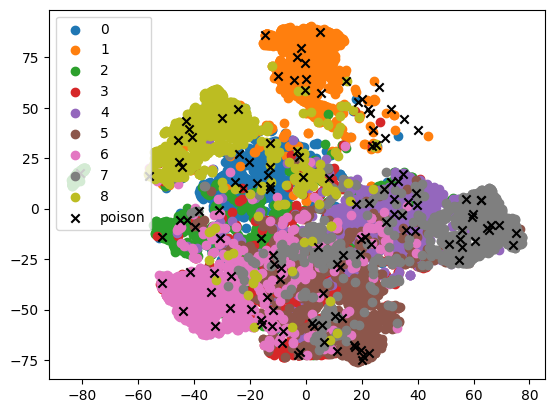

Epoch [141/300]	
	Step [0/391]	 Loss: 3.60255
	Step [50/391]	 Loss: 3.60163
	Step [100/391]	 Loss: 3.59795
	Step [150/391]	 Loss: 3.59486
	Step [200/391]	 Loss: 3.59341
	Step [250/391]	 Loss: 3.59592
	Step [300/391]	 Loss: 3.60049
	Step [350/391]	 Loss: 3.59935

	Training Loss: 3.5982671326688487
	Time Taken: 3.607465076446533 minutes
Epoch [142/300]	
	Step [0/391]	 Loss: 3.60164
	Step [50/391]	 Loss: 3.60481
	Step [100/391]	 Loss: 3.60163
	Step [150/391]	 Loss: 3.59946
	Step [200/391]	 Loss: 3.59591
	Step [250/391]	 Loss: 3.60448
	Step [300/391]	 Loss: 3.5974
	Step [350/391]	 Loss: 3.5981

	Training Loss: 3.598203096853193
	Time Taken: 3.6018155852953595 minutes
Epoch [143/300]	
	Step [0/391]	 Loss: 3.60552
	Step [50/391]	 Loss: 3.5989
	Step [100/391]	 Loss: 3.59861
	Step [150/391]	 Loss: 3.59743
	Step [200/391]	 Loss: 3.59568
	Step [250/391]	 Loss: 3.59646
	Step [300/391]	 Loss: 3.59729
	Step [350/391]	 Loss: 3.59793

	Training Loss: 3.597785596042643
	Time Taken: 3.6068822582562765 

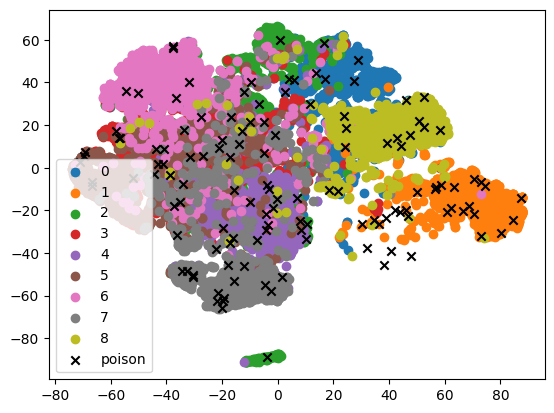

Epoch [151/300]	
	Step [0/391]	 Loss: 3.60023
	Step [50/391]	 Loss: 3.59623
	Step [100/391]	 Loss: 3.59758
	Step [150/391]	 Loss: 3.59919
	Step [200/391]	 Loss: 3.59387
	Step [250/391]	 Loss: 3.60066
	Step [300/391]	 Loss: 3.60193
	Step [350/391]	 Loss: 3.59642

	Training Loss: 3.596930458722517
	Time Taken: 3.6040988206863402 minutes
Epoch [152/300]	
	Step [0/391]	 Loss: 3.59257
	Step [50/391]	 Loss: 3.59607
	Step [100/391]	 Loss: 3.60752
	Step [150/391]	 Loss: 3.595
	Step [200/391]	 Loss: 3.60461
	Step [250/391]	 Loss: 3.60027
	Step [300/391]	 Loss: 3.59984
	Step [350/391]	 Loss: 3.5963

	Training Loss: 3.5966621981862255
	Time Taken: 3.758609044551849 minutes
Epoch [153/300]	
	Step [0/391]	 Loss: 3.59576
	Step [50/391]	 Loss: 3.59832
	Step [100/391]	 Loss: 3.59877
	Step [150/391]	 Loss: 3.60125
	Step [200/391]	 Loss: 3.59934
	Step [250/391]	 Loss: 3.5924
	Step [300/391]	 Loss: 3.59574
	Step [350/391]	 Loss: 3.59229

	Training Loss: 3.5965430687760453
	Time Taken: 3.6629159172375996 

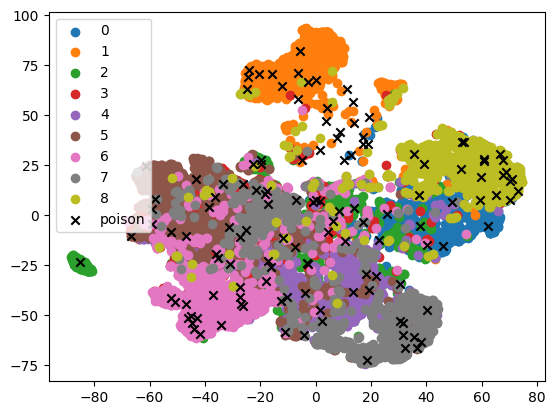

Epoch [161/300]	
	Step [0/391]	 Loss: 3.59672
	Step [50/391]	 Loss: 3.60161
	Step [100/391]	 Loss: 3.59764
	Step [150/391]	 Loss: 3.60071
	Step [200/391]	 Loss: 3.60097
	Step [250/391]	 Loss: 3.59399
	Step [300/391]	 Loss: 3.59726
	Step [350/391]	 Loss: 3.59399

	Training Loss: 3.5959532382848014
	Time Taken: 3.6611156940460203 minutes
Epoch [162/300]	
	Step [0/391]	 Loss: 3.59534
	Step [50/391]	 Loss: 3.59743
	Step [100/391]	 Loss: 3.59469
	Step [150/391]	 Loss: 3.58868
	Step [200/391]	 Loss: 3.59382
	Step [250/391]	 Loss: 3.59437
	Step [300/391]	 Loss: 3.5953
	Step [350/391]	 Loss: 3.5921

	Training Loss: 3.595684877137089
	Time Taken: 3.665816295146942 minutes
Epoch [163/300]	
	Step [0/391]	 Loss: 3.59969
	Step [50/391]	 Loss: 3.59253
	Step [100/391]	 Loss: 3.59713
	Step [150/391]	 Loss: 3.59453
	Step [200/391]	 Loss: 3.60075
	Step [250/391]	 Loss: 3.59363
	Step [300/391]	 Loss: 3.60302
	Step [350/391]	 Loss: 3.59672

	Training Loss: 3.595324432148653
	Time Taken: 3.6629791100819906

KeyboardInterrupt: 

In [28]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"NEW-SimCLR-{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"NEW-SimCLR.pt-{epoch}")